# Spike Separation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from utils import es_utils as es
from utils import itd_utils as itd
from utils import prob_utils as prob
from scipy.io import wavfile
%matplotlib inline
from scipy.io import wavfile
from scipy.signal import hilbert
import os
#from scipy.signal.filter import envelope
from scipy.stats import pearsonr
from __builtin__ import False, True
from collections import OrderedDict
import cPickle as pkl
from tqdm import tqdm
from beamforming import Beamformer
import IPython.display as ipd

ImportError: cannot import name es_utils

In [ ]:
data_location = 'data/iscas2017/aedat_files/'
cache_location = 'data/iscas2017/itds/'
estimate_location = 'data/iscas2017/estimates/'
prior_location = 'data/iscas2017/priors/'
basedir = '/Data/Dropbox/Shared ISCAS2017Submissions/RecordingUZHospitalSep2017/'

# beeps will be only for these 2 files.
# TODO find beeps for short files.
file_names = ['clean_concurrent_long_3_streams', 'noise_concurrent_long_3_streams']

# extraction of beep
beep_starts = np.array([239171242, 3030051460], dtype=np.uint32)
first_offset = np.array([2.5 * 1e6], dtype=np.uint32)
speech_onsets = beep_starts + first_offset

# general stuff
num_bins = 80
max_itd = 800e-6
num_channels = 64

# Extract events

In [14]:
file_idx = 0
file_name = file_names[file_idx]

# load aer data
timestamps, addresses = es.loadaerdat(data_location + file_name + '.aedat')
print timestamps.shape
print addresses.shape

# filter events from after the beep - TODO better
addresses = addresses[timestamps > speech_onsets[file_idx]]
timestamps = timestamps[timestamps > speech_onsets[file_idx]] - speech_onsets[file_idx]

# decode events - side and neuron index
timestamps, ears, types = es.decode_ams1b(timestamps, addresses, reset_time_stamps=False)
print timestamps.shape
print ears.shape
print types.shape

# calculate itds
cache_file_name = 'debug' + '.npz'
itds, itd_indices = itd.get_itds(timestamps, ears, types, save_to_file=cache_file_name, 
                                 verbose=False, max_itd=max_itd)

print itds.shape
print itd_indices.shape


(8064863,)
(8064863,)
(8019293,)
(8019293,)
(8019293,)
(4122726,)
(4122726,)


# Separate into different runs

In [3]:
data = np.load('debug' + '.npz')
timestamps, itds, itd_indices = data['timestamps'], data['itds'], data['itd_indices']
types = data['types']
timestamps = timestamps[itd_indices]
types = types[itd_indices]
print('{}_{}, {}'.format(file_idx, file_name, timestamps[-1] - timestamps[0]))
# there are three streams in each of them
speech_time, silence_time = 30., 2.
num_conv_bits = 9

for conversation_idx in range(3): # mm/mf/ff
    for bit_idx in range(num_conv_bits): # combination
        
        indices = np.where((timestamps > conversation_idx * num_conv_bits * (speech_time + silence_time) + bit_idx * (speech_time + silence_time)) &
                       (timestamps < conversation_idx * num_conv_bits * (speech_time + silence_time) + (bit_idx + 1) * (speech_time + silence_time)))[0]
        s_timestamps, s_itds, s_types = timestamps[indices], itds[indices], types[indices]
        s_timestamps = s_timestamps - (conversation_idx * num_conv_bits * (speech_time + silence_time) + bit_idx * (speech_time + silence_time))
        np.savez(cache_location + stream_file_names[file_idx] + str(conversation_idx) + '_' + str(bit_idx), 
                 itds=s_itds, timestamps=s_timestamps, types=s_types)    
 

0_clean_concurrent_long_3_streams, 1217.0513916
Concurrent 0_0_0, 30.0154399872
Concurrent 0_0_1, 30.020149231
Concurrent 0_0_2, 30.0298233032
Concurrent 0_0_3, 30.0339660645
Concurrent 0_0_4, 30.025100708
Concurrent 0_0_5, 30.0321655273
Concurrent 0_0_6, 30.037902832
Concurrent 0_0_7, 30.039932251
Concurrent 0_0_8, 30.0392456055
Concurrent 0_0 done
Concurrent 0_1_0, 30.044921875
Concurrent 0_1_1, 30.0531311035
Concurrent 0_1_2, 30.0450744629
Concurrent 0_1_3, 30.0548095703
Concurrent 0_1_4, 30.0516967773
Concurrent 0_1_5, 30.0614013672
Concurrent 0_1_6, 30.0631103516
Concurrent 0_1_7, 30.0728149414
Concurrent 0_1_8, 30.0614624023
Concurrent 0_1 done
Concurrent 0_2_0, 30.0825805664
Concurrent 0_2_1, 30.0778198242
Concurrent 0_2_2, 30.0995483398
Concurrent 0_2_3, 30.0924072266
Concurrent 0_2_4, 30.1061401367
Concurrent 0_2_5, 30.0989990234
Concurrent 0_2_6, 30.1024169922
Concurrent 0_2_7, 30.0975952148
Concurrent 0_2_8, 30.1052246094
Concurrent 0_2 done
File 0 done.
1_noise_concurrent_l

# Estimate probabilities

In [26]:
# change sigma for concurrent
stream_file_names = ['clean_concurrent_long_', 'noise_concurrent_long_']

sigma = 45  # works slighlty better then 5 for concurrent
index_angles = np.array([[0, -90], [1, -60], [2, -30], [3, 0], [4, 30], [5, 60], [6, 90]])
estimate_location = 'data/iscas2017/estimates/'
prior_location = 'data/iscas2017/priors/'
channel_low = 10
channel_high = 20
num_channels = 64
priors = np.load(prior_location + 'prior_combined_male_female' + '_c{}_c{}.npy'.format(channel_low, channel_high))
num_angles = len(priors)
for file_idx, file_name in enumerate(stream_file_names): # clean and noise
    for s_idx in range(3): # mm/mf/ff
        for bit_idx in range(9): # position
            
            # load cached itds
            data = np.load(cache_location + file_name + str(s_idx) + '_' + str(bit_idx) + '.npz')
            itds, timestamps, types = data['itds'], data['timestamps'], data['types']
            channels = types % num_channels
            indices = np.where((channels >= channel_low) & (channels <= channel_high))[0]
            itds, timestamps = itds[indices], timestamps[indices]
            
            estimate_file = estimate_location + file_name + str(s_idx) + '_' + str(bit_idx) + '_combined_male_female_prior_c{}_c{}_sigma_{}.npz'.format(channel_low, channel_high, sigma)
            
            estimates, argmax_estimates = prob.estimate(itds, np.ones(num_angles) / num_angles, prob.get_transition_probabilities(index_angles, sigma=sigma),
                                                        itd.get_itd_dict(max_itd, num_bins), priors, save=estimate_file)
 

# Extract Spikes and Ground Truth

In [24]:
def assign_spikes(file_name, bit_idx, s_idx, sigma=30, channel_low=10, channel_high=20, max_len=5, debug=False, fs=44100):
    
    # load data
    estimate_file = estimate_location + file_name + str(s_idx) + '_' + str(bit_idx) + '_combined_male_female_prior_c{}_c{}_sigma_{}.npz'.format(channel_low, channel_high, sigma)
    data = np.load(estimate_file)
    args = data['argmax_estimates']

    data = np.load(cache_location + file_name + str(s_idx) + '_' + str(bit_idx) + '.npz')
    itds, timestamps, types = data['itds'], data['timestamps'], data['types']
    channels = types % num_channels
    indices = np.where((channels >= channel_low) & (channels <= channel_high))[0]
    itds, timestamps = itds[indices], timestamps[indices]
    ch = channels[indices]
    
    # assign spikes based on estimated position -> argmax estimates
    assigned = []
    for i in range(7):
        assigned.append({'timestamps': timestamps[args==i], 'ch': ch[args==i]})
        
    # do spike count
    win_len = 10e-3 # is s
    n_samples = int(win_len * fs)
    spike_count = []
    spike_counts = []
    
    corrs = []
    for pos in range(7):
        t = np.arange(0,max_len,1.0 / fs)

        spike_count = []
        for i in range(len(t) - n_samples):
            _tmp = assigned[pos]['timestamps']
            _tmp = _tmp[_tmp >= t[i]]
            _tmp = _tmp[_tmp <= t[i + n_samples]]
            spike_count.append(len(_tmp))

        spike_count.extend([0] * n_samples)
        spike_counts.append(np.array(spike_count).astype('float32') / n_samples)
    
    if not debug:
        return spike_counts
    else:
        return spike_counts, assigned

def extract_ground_truth(exp_name, noise, length, chunk, spk, win_len=3000, max_len=None, debug=False):
    
    positions = [[ 1, 11], [ 2, 10], [ 3,  9], [ 1, 12], [ 3, 11], [ 1,  9], [12, 11], [ 2,  3], [ 7,  5]]
    [fs, y] = wavfile.read(os.path.join(basedir, 'gt_{}_{}{}/gt_{}_{}{}_ch{}.wav'.format(exp_name, noise, length, exp_name, noise, length, positions[chunk][spk])))
    seg_len = 7 if length == '' or length == '_short' else 32
    if 'v' in exp_name:
        seg_len = 17
    t = np.arange(0,seg_len-2,1.0 / fs)
    y = y[chunk * seg_len * fs:(chunk + 1) * seg_len * fs]
    y = y[2 * fs:]
    
    y = y if max_len is None else y[:max_len*fs]
    t = t if max_len is None else t[:max_len*fs]

    env = np.abs(hilbert(y))

    ACT = np.zeros_like(t)
    ACT[env>0.1*np.max(env)] = 1
    overlap = 1

    low_pass = []
    for i in range(0,len(t) - win_len):
        low_pass.append(np.sum(ACT[i: i + win_len]))
    low_pass = np.concatenate([np.zeros((win_len,)), low_pass])
    if not debug: 
        return low_pass
    else:
        return low_pass, ACT, y, t

# Example

In [1]:
positions = [[ 1, 11], [ 2, 10], [ 3,  9], [ 1, 12], [ 3, 11], [ 1,  9], [12, 11], [ 2,  3], [ 7,  5]]
index_angles = [-90, -60, -30, 0, 30, 60, 90]
map_pos = [0, 30, 60, 90, 60, 30, 0, -30, -60, -90, -60, -30]
exp_name = 'concmf'
s_idx_map = {'concmm': 0, 'concmf':1, 'concff': 2}
fs = 44100
noise = 'clean'
length = '_long'
chunk = 5
sigma = 45
spk = 1

run_name =  "{}_{}{}".format(exp_name, noise, length)

file_name = '{}_concurrent_long_'.format(noise)
s_idx = s_idx_map[exp_name]

# print "\testimated/gt  {}/{}".format(index_angles[np.argmax(corrs)], map_pos[positions[chunk][spk] % 12])
t = np.arange(0, 5, 1.0 / 44100.0)

spike_counts = assign_spikes(file_name, chunk, s_idx, sigma=sigma, max_len=5)

low_pass = extract_ground_truth(exp_name, noise, length, chunk, spk, max_len=5)


corrs = []
for i in range(7):
    corrs.append(pearsonr(spike_counts[i], low_pass)[0])

plt.plot(t, low_pass, label='low_pass')
plt.plot(t, spike_counts[np.argmax(corrs)] * np.max(low_pass), label='spikes')

print "\testimated/gt  {}/{}".format(index_angles[np.argmax(corrs)], map_pos[positions[chunk][spk] % 12])
# print corrs

_ = plt.legend()

NameError: name 'np' is not defined

In [2]:
file_name = '../Shared ISCAS2017Submissions/RecordingsDungeon/'

# positions = ['10_1','10_6','1_8','2_9','3_9','4_7','6_5','8_3','9_7']
positions = [[10,1],[10,6],[1,8],[2,9],[3,9],[4,7],[6,5],[8,3],[9,7]]

# generate all filenames for all the positions
file_names = {}
for pos in positions:
    file_names[pos[0]] = {'white_speaker':[], 'black_speaker':[]}
    file_names[pos[1]] = {'white_speaker':[], 'black_speaker':[]}
for pos in positions:
    for sample in ['A','B','C','D']:
        file_names[pos[0]]['white_speaker'].append(file_name + '%d_%d_%s' %(pos[0], pos[1], sample)) 
        file_names[pos[1]]['black_speaker'].append(file_name + '%d_%d_%s' %(pos[0], pos[1], sample))


In [3]:
# list of names for priors

n = ['1_8','2_9','3_9','4_7','6_5','6_5','9_7','8_3','2_9','10_1']
to_pick = [0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
file_names = ['dungeon_concurrent_' + x +  '_A.aedat' for x in n]
print file_names

['dungeon_concurrent_1_8_A.aedat', 'dungeon_concurrent_2_9_A.aedat', 'dungeon_concurrent_3_9_A.aedat', 'dungeon_concurrent_4_7_A.aedat', 'dungeon_concurrent_6_5_A.aedat', 'dungeon_concurrent_6_5_A.aedat', 'dungeon_concurrent_9_7_A.aedat', 'dungeon_concurrent_8_3_A.aedat', 'dungeon_concurrent_2_9_A.aedat', 'dungeon_concurrent_10_1_A.aedat']


In [16]:
# general stuff
num_bins = 80
max_itd = 800e-6
num_channels = 64
channel_low = 0
channel_high = 64

PRIORS = []
ITDS = []
TIMESTAMPS = []
TYPES = []
for t, name in zip(to_pick[:2], file_names[:2]):
    print name
    # load aer data
    timestamps, addresses = es.loadaerdat(base_dir + name)

    # filter trigger and reset
    trig = np.where(timestamps<4000)[0][0]
    addresses = addresses[trig:]
    timestamps = timestamps[trig:]
    timestamps -= timestamps[0]

    # decode events - side and neuron index
    timestamps, ears, types = es.decode_ams1c(timestamps, addresses, return_type=True)

    # cache_file_name = 'debug' + '.npz'
    itds, itd_indices = itd.get_itds(timestamps, ears, types, 
                                    verbose=False, max_itd=max_itd)
    
    timestamps = timestamps[itd_indices]
    types = types[itd_indices]
    
    ITDS.append(itds)
    TIMESTAMPS.append(timestamps)
    TYPES.append(types)
    
    channels = types % num_channels
    indices = np.where((channels >= channel_low) & (channels <= channel_high))[0]
    itds_f, timestamps_f = itds[indices], timestamps[indices]
    
    idxs = separate_dungeon_files(timestamps_f, 'A')
    # only selected
    idxs = idxs[t]
    itds_f, timestamps_f = itds_f[idxs], timestamps_f[idxs]

    hist, bin_edges = np.histogram(itds_f, 100, density=True)
    PRIORS.append(hist)

dungeon_concurrent_1_8_A.aedat
dungeon_concurrent_2_9_A.aedat


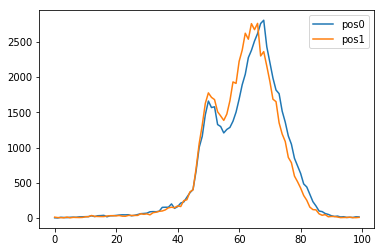

In [17]:
for i in range(2):
    plt.plot(PRIORS[i], label='pos' + str(i))
plt.legend()


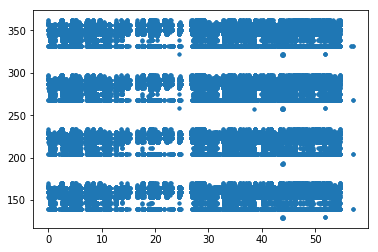

In [13]:
plt.plot(TIMESTAMPS[0], TYPES[0], '.')

In [11]:
ID = 3
priors = np.array(PRIORS)
num_angles = len(priors)
num_bins = 100
itds = ITDS[ID]
index_angles = np.array([[0, -90], [1, -70], [2, -50], [3, -30], [4, -10], [5, 10], [6, 30], [7, 50], [8, 70], [9, 90]])
sigma=45
estimates, argmax_estimates = prob.estimate(itds, np.ones(num_angles) / num_angles, prob.get_transition_probabilities(index_angles, sigma=sigma),
                                                        itd.get_itd_dict(max_itd, num_bins), priors)


(367336, 10)
(367336,)


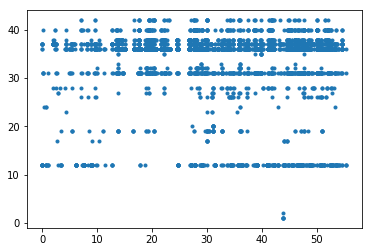

In [44]:
print estimates.shape
print argmax_estimates.shape
channel_low = 0
channel_high = 64
# plt.plot(argmax_estimates[:10000])
channels = TYPES[ID] % num_channels
indices = np.where((channels >= channel_low) & (channels <= channel_high))[0]
timestamps = TIMESTAMPS[ID][indices]

ch = TYPES[ID][indices]
args=argmax_estimates[indices]
assigned = []

for i in range(10):
    assigned.append({'timestamps': timestamps[args==i], 'ch': ch[args==i]})

plt.plot(assigned[8]['timestamps'], assigned[8]['ch'] % 64, '.')




In [45]:
# do spike count
fs = 24000.0
win_len = 100e-3 # is s
n_samples = int(win_len * fs)
spike_count = []
spike_counts = []
max_len = 60

corrs = []
for pos in range(10):
    t = np.arange(0,max_len,1.0 / fs)

    spike_count = []
    for i in tqdm(range(len(t) - n_samples)):
        _tmp = assigned[pos]['timestamps']
        _tmp = _tmp[np.where(np.logical_and(_tmp >= t[i], _tmp <= t[i + n_samples]))]
        spike_count.append(len(_tmp))

    spike_count.extend([0] * n_samples)
    spike_counts.append(np.array(spike_count).astype('float32') / n_samples)


100%|██████████| 1437600/1437600 [00:12<00:00, 118197.38it/s]


-0.095651391274
-0.122184798171
-0.127421597102
-0.0750606894871
0.0581372086891
0.408501796043
0.518477341061
0.510734131918
0.483631190782
0.459515388596


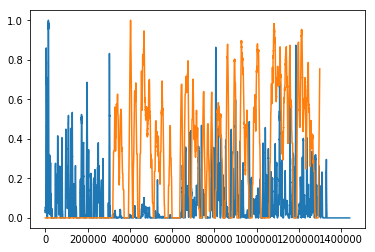

In [63]:
#for i in range(10):
plt.plot(spike_counts[3] / np.max(spike_counts[3]), label='pos ' + str(i))
# y1, y2 = extract_gt_dungeon()
plt.plot(y2 / np.max(y2))

min_len = min([len(y2), len(spike_counts[0])])

for i in range(10):
    print pearsonr(spike_counts[i][:min_len], y2[:min_len])[0]


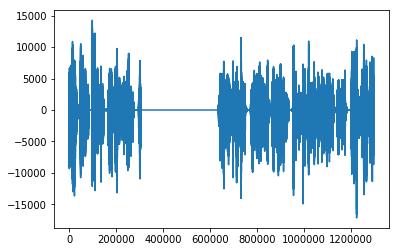

In [59]:
tpe = 'A'
[fs, y1] = wavfile.read(base_dir + 'edited' + tpe + '1_T.wav')

plt.plot(y1[24500:])

40.34375


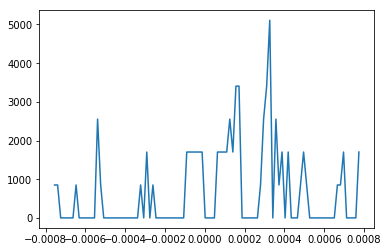

In [42]:
timestamps_i = timestamps[itd_indices]
types_i = types[itd_indices]
channel_low = 0
channel_high = 9
channels = types_i % num_channels
indices = np.where((channels >= channel_low) & (channels <= channel_high))[0]
itds_f, timestamps_f = itds[indices], timestamps_i[indices]

hist, bin_edges = np.histogram(itds_f, 100, density=True)
plt.plot(bin_edges[:-1], hist)
print 15 * 22050.0 / 24000 + 26.5625

In [1]:
# mapping
def separate_dungeon_files(timestamps, sample):
    # IN: numpy array timestamps from a certain sample in seconds and char indicating which sample (A/B/C/D) it belongs to
    # OUT: array of the indices of timestamps where only the white speaker is active
    if sample == 'A':
        # for sample A this is the data for times between 0s and 15s
        return np.where(timestamps < 12.78125), \
               np.where(np.logical_and(timestamps >= 12.78125,timestamps < 26.5625)), \
               np.where(timestamps > 26.5625)
    
    elif sample == 'B':
        # for sample B this is the data for times between 15s and 30s
        return np.where(np.logical_and(timestamps>=12.78125,timestamps<26.5625)), \
               np.where(np.logical_and(timestamps>=26.5625,timestamps<40.34375)), \
               np.where(np.logical_and(timestamps<12.78125,timestamps>=40.34375))
    elif sample == 'C':
        # for sample C this is the data for times between 0s and 15s
        return np.where(timestamps<12.78125), \
               np.where(np.logical_and(timestamps>=26.5625,timestamps<40.34375)), \
               np.where(np.logical_or(np.logical_and(timestamps>=12.78125,timestamps<26.5625)), timestamps > 40.34375),
    elif sample == 'D':
        # for sample D this is the data for times between 30s and 45s
        return np.where(np.logical_and(timestamps>=26.5625,timestamps<40.34375)), \
               np.where(np.logical_and(timestamps>=12.78125,timestamps<26.5625)), \
               np.where(np.logical_and(timestamps<12.78125,timestamps>=40.34375))
def extract_gt_dungeon(tpe='A'):
    
    [fs, y1] = wavfile.read(base_dir + 'edited' + tpe + '1_T.wav')
    [fs, y2] = wavfile.read(base_dir + 'edited' + tpe + '8_T.wav')
    fs = 24000
    # trigger
    y1 = y1[24500:]
    y2 = y2[24500:]
    seg_len = len(y1) / 24000.0
    t = np.arange(0,seg_len,1.0 / fs)

    win_len=10000
    
    env = np.abs(hilbert(y1))
    ACT = np.zeros_like(t)
    ACT[env>0.1*np.max(env)] = 1
    low_pass1 = []
    for i in range(0,len(t) - win_len):
        low_pass1.append(np.sum(ACT[i: i + win_len]))
    low_pass1 = np.concatenate([np.zeros((win_len,)), low_pass1])
    
    env = np.abs(hilbert(y2))
    ACT = np.zeros_like(t)
    ACT[env>0.1*np.max(env)] = 1
    low_pass2 = []
    for i in range(0,len(t) - win_len):
        low_pass2.append(np.sum(ACT[i: i + win_len]))
    low_pass2 = np.concatenate([np.zeros((win_len,)), low_pass2])
    
    return low_pass1, low_pass2


# Beamforming

Estimating forward mapping A 0... 
Estimating mu 0...
MU 0 : 1.78202208149e-11
spec is (257, 7933, 4)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // r

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // r

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // r

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512,) // recon: (512,)
(512,)
c: (512

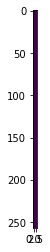

In [6]:
base_dir = './recordings_dungeon/'
[fs, x_mix] = wavfile.read(base_dir + 'dungeon_concurrent_1_8_A_1.wav')

# 

x1_calib = x_mix[:int(fs * 12.78125)]
x2_calib = x_mix[int(fs * 12.78125):int(fs * 26.5625)]
x_mix = x_mix[int(fs * 26.5625):]

bf = Beamformer(n_ch=4, n_fft=512, fs=fs, overlap=0.25, mode='LCMV', n_speakers=2)

bf.estimate_fw_mapping(x1_calib.T, speaker_idx=0)

x_spec = bf.specGramFast(x_mix.T, bf.HAN2, bf.n_chunk).T  # if i % 2 == 1:
bf.step_bf(x_spec)

# doing 0
idx = 0
plt.figure()
plt.imshow(np.abs(bf.W[0]))

print "spec is {}".format(x_spec.shape)
t = int(x_spec.shape[0] * x_spec.shape[1]) 
recon = np.zeros((t,))

for i in range(x_spec.shape[1]-1): 
    _s = np.einsum('ab,ab->a', np.conj(bf.W[idx]), x_spec[:, i, :])
    _c = np.fft.irfft(_s) * bf.HAN2
    print _c.shape
#     print "c: {} // recon: {}".format(_c.shape, recon[i * bf.n_chunk:i * bf.n_chunk + len(_c)].shape)
    recon[i * bf.n_chunk:i * bf.n_chunk + len(_c)] += _c / 4.0


ipd.Audio(recon, rate=fs)


